In [1]:
import torch
import matplotlib.pyplot as plt

from torch.distributions import MixtureSameFamily, Categorical

from distributions import CircularProjectedNormal

#torch.manual_seed(42)

# Optimization

In [2]:
import numpy as np

import torch.nn as nn
import torch.optim as O
import torch.distributions as D

## Generate Training Data

### Define Ground Truth Distribution

In [3]:
# ground truth loc parameters
mu = torch.tensor(
    [
        [-2.19, -2.09],
        [-0.19, 2.09]
    ]
)

# ground truth covariance matrix
sig11 = .9
sig21 = .4
rho1 = .5
sig12 = .58
sig22 = .4
rho2 = -.84
sigma = torch.tensor(
    [
        [[sig11**2, rho1*sig11*sig21], [rho1*sig11*sig21, sig21**2]],
        [[sig12**2, rho2*sig12*sig22], [rho2*sig12*sig22, sig22**2]]
    ]
)

# ground truth projected normal distribution
mix = Categorical(torch.ones(2))
comp = CircularProjectedNormal(mu, sigma)
true_dist = MixtureSameFamily(mix, comp)

### Sample Ground Truth Distribution

In [4]:
# multivariate normal sample
X = D.MultivariateNormal(mu[0], sigma[0]).sample((500,))
Y = D.MultivariateNormal(mu[1], sigma[1]).sample((500,))

# project to circle
U = X/X.norm(dim = 1)[:,None]
V = Y/Y.norm(dim = 1)[:,None]

### Plot

(-1.1, 1.1)

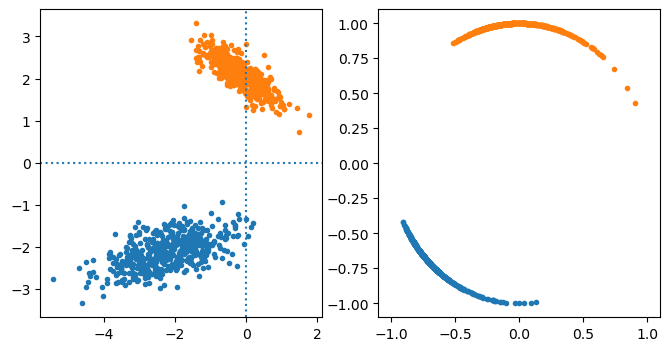

In [5]:
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.plot(X[:,0], X[:,1], '.')
plt.plot(Y[:,0], Y[:,1], '.')
plt.axvline(0, ls = ':')
plt.axhline(0, ls = ':')

plt.subplot(122)
plt.plot(U[:,0], U[:,1], '.')
plt.plot(V[:,0], V[:,1], '.')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])

## Define Variables

### Hyperparameters

In [6]:
num_epochs = 4048
n_components = 2

### Decision Variables

In [7]:
loc = torch.randn(n_components, 2)
param_loc = nn.Parameter(loc/loc.norm(dim = 1))
param_sig = nn.Parameter(torch.ones(n_components))
param_gam = nn.Parameter(torch.zeros(n_components))

## Define Optimizer

In [8]:
optimizer = O.Adam(params = (param_loc,param_sig, param_gam), lr = 0.001)

In [9]:
U = torch.vstack((U,V))

## Optimize Parameters

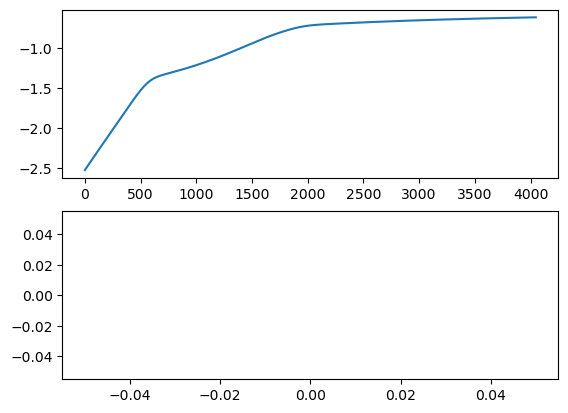

In [10]:
hist = np.zeros((num_epochs,2))

theta = torch.linspace(0, 2*torch.pi, steps = 1000)
xy = torch.stack((torch.cos(theta), torch.sin(theta))).T

for epoch in range(num_epochs):
    # zero gradients
    optimizer.zero_grad()

    # construct covariance matrix
    S = torch.stack((
        torch.stack((param_sig**2 + param_gam**2, param_gam)),
        torch.stack((param_gam, torch.tensor(n_components*[1.])))
    )).permute(2,0,1)

    # construct covariance matrix
    #S = torch.stack((
    #    torch.stack((torch.tensor(n_components*[1.]), torch.tensor(n_components*[0.]))),
    #    torch.stack((torch.tensor(n_components*[0.]), torch.tensor(n_components*[1.])))
    #)).permute(2,0,1)
    
    # define distribution
    mix = Categorical(torch.ones(n_components))
    comp = CircularProjectedNormal(param_loc, S)
    dist = MixtureSameFamily(mix, comp)

    # compute loss
    loss = -dist.log_prob(U).mean()

    with torch.no_grad():
        lnp = true_dist.log_prob(xy)
        lnq = dist.log_prob(xy)
        p = lnp.exp()
        kl = (p*lnp - p*lnq).mean()
        
    loss.backward()
    optimizer.step()

    hist[epoch, 0] = -loss.item()
    hist[epoch, 1] = kl

plt.subplot(211)
plt.plot(hist[:,0])

plt.subplot(212)
plt.plot(hist[:,1])

In [11]:
param_loc

Parameter containing:
tensor([[-1.9029, -1.8198],
        [-0.2674,  2.9847]], requires_grad=True)

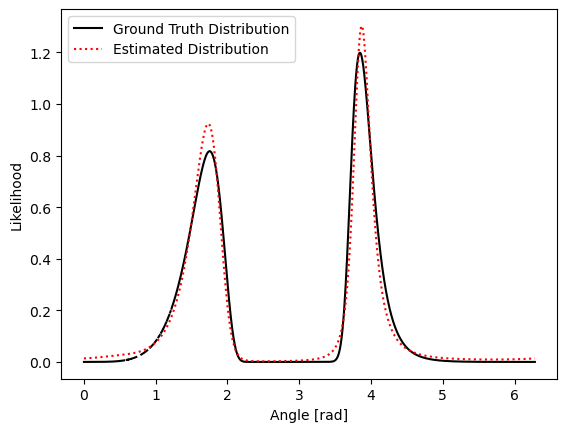

In [12]:
theta = torch.linspace(0, 2*torch.pi, steps = 1000)
xy = torch.stack((torch.cos(theta), torch.sin(theta))).T

# true likelihood
p = true_dist.log_prob(xy).exp()

# estimated likelihood
q = dist.log_prob(xy).exp().detach()

# plot
plt.plot(theta, p, 'k', label = 'Ground Truth Distribution')
plt.plot(theta, q, 'r:', label = 'Estimated Distribution')
plt.xlabel('Angle [rad]')
plt.ylabel('Likelihood')
plt.legend()

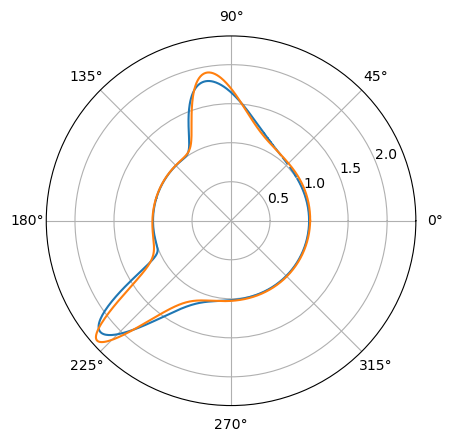

In [13]:
plt.polar(theta, 1 + p)
plt.polar(theta, 1 + q)

# Bayesian Approach

In [17]:
from distributions import InverseGamma
from torch.distributions import MultivariateNormal, Normal

In [326]:
mu_samp = torch.zeros(2)
gam_samp = torch.zeros(1)
sig_samp = torch.ones(1)
r_samp = torch.ones(len(V))
S_inv = torch.eye(2)

In [327]:
samp = torch.zeros((10000, 4))

for i in range(10000):
    A = (V[...,None,:]@S_inv@V[...,None])[...,0,0]
    B = (V[...,None,:]@S_inv@mu_samp[...,None])[...,0,0]

    ratio = B/A
    nu = (-0.5*A*(r_samp - ratio)**2).exp()*torch.rand(len(V)) + 0.000001
    sq_root = (-2*nu.log()/A).sqrt()

    Rho1 = ratio - torch.vstack((ratio, sq_root)).min(dim = 0).values
    Rho2 = ratio + sq_root

    r_samp = ((Rho2**2 - Rho1**2)*torch.rand(len(V)) + Rho1**2).sqrt()
    X_samp = r_samp[:,None]*V

    cen = X_samp - mu_samp
    num = cen.prod(dim = 1).sum()/sig_samp
    den = (cen[:,1]**2).sum()/sig_samp + 1.
    gam_samp = Normal(num/den, den.sqrt()).sample()

    concentration = len(V)/2 + .1
    rate = .5*((X_samp[:,0] - (mu_samp[0] + gam_samp*(X_samp[:,1] - mu_samp[1])))**2).sum() + .1
    sig_samp = InverseGamma(concentration, rate).sample()

    S_inv = 1/sig_samp*torch.tensor([[1., -gam_samp],[-gam_samp, sig_samp + gam_samp**2]])

    mu_S = torch.linalg.inv(len(V)*S_inv + torch.eye(2)/1000.)
    mu_samp = MultivariateNormal(X_samp.mean(dim = 0), mu_S).sample()

    samp[i,[0,1]] = mu_samp
    samp[i,2] = sig_samp
    samp[i,3] = gam_samp

In [328]:
samp[5000:].shape

torch.Size([5000, 4])

In [329]:
bleh = samp[5000:,[0,1]]
blah = torch.ones((5000, 2, 2))
blah[:,0,0] = samp[5000:, 2] + samp[5000:, 3]**2
blah[:,1,0] = samp[5000:, 3]
blah[:,0,1] = samp[5000:, 3]

In [330]:
ll = torch.zeros(len(xy))
for j in range(5000):
    ll += CircularProjectedNormal(bleh[j], blah[j]).log_prob(xy)

In [332]:
samp

tensor([[ 4.6977e-01,  1.0831e+00,  9.8158e+01, -8.5392e+00],
        [-1.3650e-01,  1.4404e+00,  3.7524e+00,  2.1120e+00],
        [ 7.9775e-01,  1.6755e+00,  3.3344e+01, -9.2309e+00],
        ...,
        [-1.6844e+00,  3.8945e+01,  1.3575e+02, -3.8676e+00],
        [-1.5557e+00,  3.8904e+01,  1.3549e+02,  1.2864e+00],
        [-1.5753e+00,  3.8890e+01,  1.4960e+02,  5.2175e+00]])